In [3]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
from dark import *
from wrn4 import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [67]:
MASKS = 'train.csv'

PATH = Path('./')
TRAIN = Path('train512/')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
seg_aug = pd.read_csv('../aug/augment.csv', header=None)
seg_aug.columns = seg.columns
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [43]:
len(seg),len(seg_aug)

(31072, 68093)

In [77]:
df = pd.merge(seg, seg_aug,'outer'); len(df)

99165

In [14]:
arch = Darknet([1,2,4,4,4], 28, 32, se=True, nf_in=4);
# arch = wrn_22_10()

In [15]:
model = create_body(arch)
sd = torch.load('models/dk_444_se_256.pth', map_location=lambda storage, loc: storage)
names = set(model.state_dict().keys())
for n in list(sd.keys()): # list "detatches" the iterator
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
model.load_state_dict(sd)
weight = model.layers[0][0].weight
model.layers[0][0] = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.layers[0][0].weight = nn.Parameter(weight[:, :3, :,:])
model

Darknet(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
    (2): ResLayerSE(
      (conv1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [21]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.1, max_warp=0.4)

In [87]:
def get_data(sz=64, bs=64, pct=0.2, sample=5000):
#     sz, pct, bs = 64, 0.2, 64
    src = (ImageItemList.from_df(df=df, path=PATH, folder=TRAIN_AUG, suffix='.png')
           .random_split_by_pct(pct)
           .label_from_df(sep=' ', classes=classes)
           .add_test([TEST/f for f in test_names]))
    data = (src.transform(tfms, size=sz))
    #         .databunch(bs=bs).normalize(stats))

    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], num_samples=sample)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl, val_dl, test_dl).normalize(stats)

In [57]:
data = get_data()

In [58]:
data.classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27']

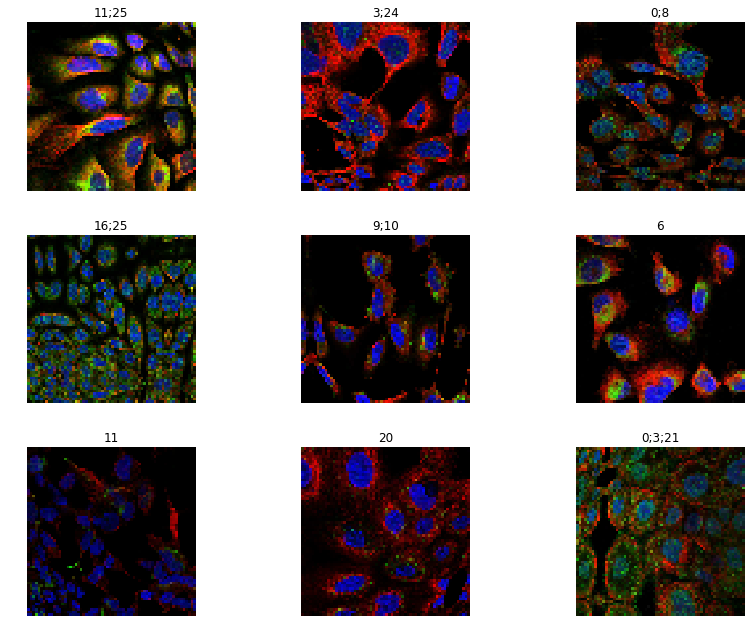

In [59]:
data.show_batch(rows=3, figsize=(12,9))

In [60]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, model , metrics=[accuracy_thresh, f1])
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
    learn.split((arch.layers[11],arch.layers[20]))  #Split for 444 model [11,20]
    return learn.mixup(stack_y=False)

# 64

In [88]:
data = get_data(sz=64, bs=256, pct=0.1, sample=None)
learn = get_learner(data, focal=False, fp16=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


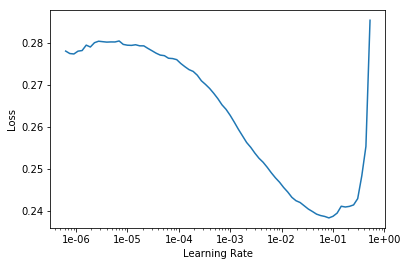

In [62]:
learn.lr_find()
learn.recorder.plot()

In [89]:
lr=5e-3

In [90]:
learn.load('dk3_444_se_64');

In [ ]:
%time learn.fit_one_cycle(20, lr, wd=0.3, div_factor=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_thresh,f1


In [ ]:
learn.save('dk3_444_se_64')

# 128

In [ ]:
learn.data = get_data(sz=128, bs=64, pct=0.1, sample=None)
# learn = get_learner(data, focal=True, fp16=True)

In [ ]:
%time learn.fit_one_cycle(10, lr/3, wd=0.2, div_factor=10, pct_start=0.5)

In [ ]:
learn.save('dk3_444_se_128')

# 256

In [73]:
data = get_data(256, 24, 0.01, sample=None)

In [74]:
learn = get_learner(data, focal=True, fp16=True)

In [30]:
# learn.layer_groups = split_model_idx(arch, [19,48,103, 158, -3])
# learn.split((arch.layers[11],arch.layers[20]))

In [29]:
learn.load('dk_444_se_128');

In [30]:
learn.freeze()

In [31]:
%time learn.fit_one_cycle(10, slice(1e-3), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 1:11:18
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.654233    0.633427    0.969925         0.503498  (07:08)
2      0.621339    0.602995    0.971217         0.505410  (07:08)
3      0.617080    0.593016    0.970395         0.501920  (07:08)
4      0.619088    0.605670    0.970747         0.497142  (07:07)
5      0.598674    0.600169    0.971452         0.494520  (07:08)
6      0.584079    0.597105    0.970747         0.500710  (07:07)
7      0.590395    0.576506    0.973449         0.527191  (07:06)
8      0.577506    0.568232    0.971570         0.501305  (07:08)
9      0.566611    0.568505    0.973332         0.518704  (07:08)
10     0.582836    0.565819    0.972274         0.518897  (07:07)

CPU times: user 29min 3s, sys: 41min 35s, total: 1h 10min 38s
Wall time: 1h 11min 18s


In [32]:
learn.save('dk_444_se_256');

In [33]:
learn.unfreeze()

In [34]:
%time learn.fit_one_cycle(10, slice(1e-4, 1e-2/5), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 1:31:22
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.586983    0.590271    0.970865         0.511462  (09:07)
2      0.597639    0.589503    0.970277         0.507499  (09:07)
3      0.605415    0.609968    0.969220         0.480729  (09:08)
4      0.604607    0.616451    0.971335         0.510478  (09:08)
5      0.597599    0.610122    0.970512         0.496908  (09:08)
6      0.553571    0.571872    0.972039         0.515013  (09:08)
7      0.545225    0.569565    0.971805         0.508798  (09:08)
8      0.526132    0.569061    0.972744         0.509010  (09:07)
9      0.537468    0.550339    0.973567         0.519620  (09:08)
10     0.509023    0.549182    0.973684         0.530200  (09:08)

CPU times: user 44min 23s, sys: 46min 20s, total: 1h 30min 43s
Wall time: 1h 31min 22s


In [35]:
learn.save('dk_444_se_256');

In [46]:
learn = get_learner(data, focal=True, fp16=True)
learn.load('dk_444_se_256');
learn.unfreeze()

In [47]:
%time learn.fit_one_cycle(20, slice(1e-4/2, 1e-3), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 4:38:36
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.524976    0.523568    0.972811         0.513302  (13:53)
2      0.516199    0.554878    0.971429         0.499693  (13:54)
3      0.509291    0.545275    0.972811         0.506285  (13:54)
4      0.527384    0.563893    0.971889         0.510238  (13:54)
5      0.521021    0.561514    0.970507         0.489917  (13:56)
6      0.513259    0.610516    0.970853         0.501725  (13:56)
7      0.534006    0.576600    0.970046         0.479486  (13:54)
8      0.518870    0.606870    0.970737         0.478482  (13:55)
9      0.505476    0.608334    0.969355         0.476970  (13:56)
10     0.503765    0.596166    0.970968         0.488283  (13:55)
11     0.498434    0.569368    0.971198         0.495728  (13:55)
12     0.492287    0.565673    0.972005         0.500732  (13:56)
13     0.475972    0.557628    0.972465         0.503962  (13:56)
14     0.473882    0.545845    0.972696         0.522205  (13:56)

In [48]:
learn.save('dk_444_se_256v2');

[autoreload of utils failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.7/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/workspace/kaggle_hpa/utils.py", line 9, in <module>
    def open_image4d(path:PathOrStr)->Image:
NameError: name 'PathOrStr' is not defined
]


In [71]:
learn.load('dk_444_se_256');

In [61]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

## 512

Training with size = 512 does not work, I don't know why.
Probably comes from the SE module, beacuase it works without this module.

In [25]:
data = get_data_custom(500, 16, 0.01, sample = None)  #training with 512 size does not work.
learn = get_learner(data, focal=True, fp16=True)

In [18]:
learn.load('dk_444_se_256');

In [19]:
learn.freeze()

In [20]:
%time learn.fit_one_cycle(6, slice(1e-3), wd=0.3, div_factor=10, pct_start=0.3)

Total time: 5:00:48
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.805172    0.922284    0.958079         0.250193  (50:06)
2      0.833734    0.988092    0.955031         0.215251  (50:08)
3      0.840235    0.969652    0.953942         0.224623  (50:11)
4      0.771709    0.878946    0.958842         0.240016  (50:07)
5      0.771375    0.815986    0.960475         0.246118  (50:07)
6      0.721159    0.831685    0.959386         0.256636  (50:06)

CPU times: user 2h 7min 2s, sys: 2h 53min 45s, total: 5h 47s
Wall time: 5h 48s


In [21]:
learn.save('dk_444_se_500');

In [26]:
learn.load('dk_444_se_500');

In [27]:
learn.unfreeze()

In [30]:
%time learn.fit_one_cycle(10, slice(1e-4/5, 1e-3), div_factor=25, pct_start=0.3)

Total time: 9:31:30
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.675519    0.770466    0.964165         0.342275  (57:13)
2      0.679093    0.812860    0.961269         0.323943  (57:10)
3      0.676465    0.783376    0.962476         0.328304  (57:08)
4      0.622843    0.856160    0.958977         0.319174  (57:07)
5      0.629718    0.748121    0.964165         0.342526  (57:07)
6      0.626913    0.822372    0.960666         0.330728  (57:08)
7      0.575359    0.721762    0.963321         0.341208  (57:03)
8      0.553358    0.766244    0.964406         0.355758  (57:08)
9      0.571075    0.778329    0.964889         0.340282  (57:11)
10     0.547229    0.709605    0.966096         0.349183  (57:11)

CPU times: user 4h 39min 5s, sys: 4h 52min 6s, total: 9h 31min 12s
Wall time: 9h 31min 30s


In [31]:
learn.save('dk_444_se_500');

# Validation and Preds

In [68]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

Total time: 1:25:22



In [66]:
p.shape

torch.Size([11702, 28])

Compute optimal THS

In [76]:
#train data preds
learn.data.train_dl.add_tfm(to_half)
p_v, t_v = learn.get_preds(ds_type=DatasetType.Train)

In [102]:
p_v[0]>0

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.uint8)

In [103]:
t_v[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])

In [80]:
p_v_s = p_v.sigmoid()
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [81]:
ths = find_thresh(p_v_np, t_v_np); ths

array([0.03, 0.05, 0.07, 0.01, 0.  , 0.06, 0.01, 0.22, 0.01, 0.  , 0.  , 0.45, 0.08, 0.12, 0.  , 0.07, 0.01, 0.01,
       0.  , 0.  , 0.01, 0.05, 0.  , 0.  , 0.  , 0.03, 0.  , 0.01])

In [82]:
ths=array([0.52, 0.42, 0.34, 0.5 , 0.46, 0.38, 0.36, 0.41, 0.35, 0.4 , 0.41, 0.4 , 0.39, 0.43, 0.4 , 0.39, 0.37, 0.39,
       0.4 , 0.41, 0.46, 0.36, 0.31, 0.41, 0.49, 0.39, 0.31, 0.5 ])

In [83]:
f1_np(p_v_np, t_v_np, ths)

0.05433150088957027

# Sub File

In [112]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
threshold = 0.4 #ths
print(preds.shape)
# classes = np.array(data.classes)
classes = array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [113]:
classes

array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')

In [114]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_se.csv', index=False)

In [115]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 6
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 18 25 21
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 20
